In [7]:
import os 
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


In [8]:
##extract image , vggface model
model = VGG16()  ##for now i am loading here
model = Model(inputs=model.inputs,outputs=model.layers[-2].output)
##summarise
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
# ##extract fetures from image will  use dictionary
# features= {}
# ##directory= os.path.join(BASE_DIR,'Images')
# directory = r'C:\Users\adhik\Image Caption Generator\image caption\Images'
# for img_name in tqdm(os.listdir(directory)):
#     #load image from file
#     img_path = os.path.join(directory, img_name)
#     image = load_img(img_path,target_size=(224,224))
#     #convert imge to numpy array
#     image = img_to_array(image)
#     #reshape data for model
#     image = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
#     ##preprocess for vgg
#     image = preprocess_input(image)
#     #extract features
#     feature=model.predict(image,verbose=0)
#     #get imageid
#     image_id = img_name.split('.')[0]
#     #store feature
#     features[image_id] = feature

In [13]:
# #store in pickle
# pickle.dump(features, open(os.path.join('C:\\Users\\adhik\\Image Caption Generator','features.pkl'),'wb'))

In [31]:
##loading features
with open(os.path.join('C:\\Users\\adhik\\Image Caption Generator','features.pkl'),'rb') as f:
    features = pickle.load(f)

In [32]:
##loading captions?
BASE_DIR = r'C:\Users\adhik\Image Caption Generator\image caption'
with open(os.path.join(BASE_DIR,'captions.txt'),'r') as f:
    next(f)
    captions_doc=f.read()

In [33]:
##for each image id we will have corresponding caption
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    #split the line bt coma
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0],tokens[1:]  ##[0] is image id [1] caption
    #remove extension from image id
    image_id = image_id.split('.')[0]
    #convert caption list to string
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    #store the caption    
    mapping[image_id].append(caption)    

  0%|          | 0/40456 [00:00<?, ?it/s]

In [34]:
len(mapping)

8091

In [25]:
#mapping

In [26]:
##preprocessing Text Data

In [35]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]','')
            caption = caption.replace(r'\s+', ' ')
            caption = '<start> ' + " ".join([word for word in caption.split() if len(word)>1]) + ' <end>'
            captions[i] = caption

In [36]:
##before preprocess of text
mapping['667626_18933d713e']

['A girl is stretched out in shallow water',
 'A girl wearing a red and multi-colored bikini is laying on her back in shallow water .',
 'A little girl in a red swimsuit is laying on her back in shallow water .',
 '"A young girl is lying in the sand   while ocean water is surrounding her ."',
 'Girl wearing a bikini lying on her back in a shallow pool of clear blue water .']

In [37]:
#preprocess the text
clean(mapping)

In [38]:
#after preprocess
mapping['667626_18933d713e']

['<start> girl is stretched out in shallow water <end>',
 '<start> girl wearing red and multi-colored bikini is laying on her back in shallow water <end>',
 '<start> little girl in red swimsuit is laying on her back in shallow water <end>',
 '<start> "a young girl is lying in the sand while ocean water is surrounding her ." <end>',
 '<start> girl wearing bikini lying on her back in shallow pool of clear blue water <end>']

In [39]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [40]:
len(all_captions)

40455

In [41]:
all_captions[:10]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tri-colored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

In [59]:
##tokenize of the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [60]:
vocab_size

8483

In [61]:
#get max length of the caption available
max_length = max(len(caption.split())for caption in all_captions)

In [62]:
max_length

35

In [63]:
##train  test split
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.90)
train = image_ids[:split]
test = image_ids[split:]

In [89]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        X1, X2, y = [], [], []
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

                    if len(X1) == batch_size:
                        yield (
                            (tf.convert_to_tensor(X1, dtype=tf.float32),
                             tf.convert_to_tensor(X2, dtype=tf.int32)),
                            tf.convert_to_tensor(y, dtype=tf.float32)
                        )
                        X1, X2, y = [], [], []

        if len(X1) > 0:
            yield (
                (tf.convert_to_tensor(X1, dtype=tf.float32),
                 tf.convert_to_tensor(X2, dtype=tf.int32)),
                tf.convert_to_tensor(y, dtype=tf.float32)
            )


In [90]:
def create_dataset(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    output_signature = (
        (
            tf.TensorSpec(shape=(batch_size, 4096), dtype=tf.float32),  # Image features
            tf.TensorSpec(shape=(batch_size, max_length), dtype=tf.int32)  # Captions
        ),
        tf.TensorSpec(shape=(batch_size, vocab_size), dtype=tf.float32)  # Targets
    )

    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size),
        output_signature=output_signature
    )

    return dataset


In [91]:
#encoder model
#image feature layer
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256,activation='relu')(fe1)
#sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

#decoder model , concatenatte image and caption
decoder1 = add([fe2,se3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')

#plot model
#plot_model(model, show_shapes=True)


In [92]:
# Define parameters
epochs = 15
batch_size = 64
steps_per_epoch = len(train) // batch_size

# Create the dataset
train_dataset = create_dataset(
    data_keys=train,
    mapping=mapping,
    features=features,
    tokenizer=tokenizer,
    max_length=max_length,
    vocab_size=vocab_size,
    batch_size=batch_size
)

# Train the model
model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    verbose=1
)

Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 249ms/step - loss: 6.9549
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 268ms/step - loss: 5.9201
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 268ms/step - loss: 5.5426
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 268ms/step - loss: 5.4623
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 268ms/step - loss: 5.1646
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 269ms/step - loss: 5.1975
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 263ms/step - loss: 5.1312
Epoch 8/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 267ms/step - loss: 4.8405
Epoch 9/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 271ms/step - loss: 4.8981
Epoch 10/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 270ms/step - loss: 4.6704
Epoch 11/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 268ms/step - loss: 4.5361
Epoch 12/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 273ms/step - loss: 4.5229
Epoch 13/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 267ms/step - loss: 4.5962
Epoch 14/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 270ms/step - loss: 4.4638
Epoch 15/15
113

In [93]:
model.save('best_model.h5')

In [94]:
##generate caption for image


In [95]:
def idx_to_word(integer,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return  None        

In [99]:
#generate caption
def predict_caption(model,image,tokenizer,max_length):
    #add start tag for generation
    in_text = '<start>'
    #iterate over max length of sequence
    for i in range(max_length):
        #encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        #pad the sequence
        sequence = pad_sequences([sequence],max_length)
        yhat = model.predict([image, sequence],verbose=0)
        yhat=np.argmax(yhat)
        word = idx_to_word(yhat,tokenizer)
        if word is None:
            break
        ##append word as input for generating next word 
        in_text += " " + word
        if word == '<end>':
            break
    return in_text        
        

In [103]:
# !pip install --upgrade nltk


In [104]:
from nltk.translate.bleu_score import corpus_bleu
actual , predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model,features[key],tokenizer,max_length)
    actual_caption = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_caption)
    predicted.append(y_pred)

print("BLEU-1: %f" % corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print("BLEU-2: %f" % corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

TypeError: Fraction.__new__() got an unexpected keyword argument '_normalize'

In [114]:
#visualise the results 
from PIL import Image
import matplotlib.pyplot

def generate_caption(image_name):
    
#image_name = "35506150_cbdb630f4f.jpg"
    image_id  = image_name.split('.')[0]
    image_path  = os.path.join(BASE_DIR,"Images",image_name)
    image = Image.open(image_path)
    captions = mapping[image_id]
    print('---------------Actual--------------------')
    for  caption in captions:
         print(caption)
    y_pred = predict_caption(model,features[image_id],tokenizer,max_length)
    print('-----------------------Predicted------------------------')
    print(y_pred)
    plt.imshow(image)

---------------Actual--------------------
<start> blond girl standing in front of large metal fan <end>
<start> man and woman walking past record shop <end>
<start> woman and man are passing by window displaying record <end>
<start> woman and man stand outside store <end>
<start> woman with dirty blonde hair and sunglasses and man with dark hair stand in front of record store <end>
-----------------------Predicted------------------------
<start> man in red shirt and shirt and shirt and shirt and shirt and shirt and white shirt is and shirt and black and white and white and white and white and white and white and


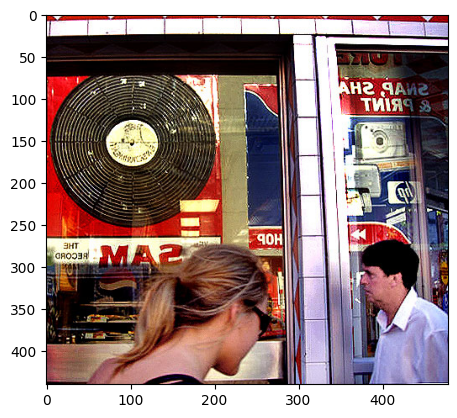

In [141]:
generate_caption("428483413_b9370baf72.jpg")

In [142]:
pwd


'C:\\Users\\adhik\\Image Caption Generator'